### Plot a batch of neural activty sequences from train and validation datasets.
---
*Last updated: 13 November 2023*

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import TwoSlopeNorm
from matplotlib.collections import LineCollection
from utils import NEURON_LABELS, init_random_seeds

# Initialize the random seeds
init_random_seeds(42)

Loading from /orcd/home/001/qsimeon/worm-graph/data/raw/neuron_master_sheet.csv.

CUDA device found.
	 GPU: NVIDIA H100 80GB HBM3


## >>> DEBUG >>>>

In [2]:
import pickle
from omegaconf import DictConfig, OmegaConf
from data._utils import load_dataset, select_desired_worms, select_labeled_neurons, rename_worm_keys
from data._utils import NeuralActivityDataset, filter_loaded_combined_dataset

In [3]:
data_config = OmegaConf.load("../configs/submodule/data.yaml").dataset
print(OmegaConf.to_yaml(data_config), end="\n\n")

use_these_datasets:
  path: null
  num_worms: null
save_datasets: false
source_datasets:
  Kato2015: all
  Nichols2017: all
  Skora2018: all
  Kaplan2020: all
  Nejatbakhsh2020: all
  Yemini2021: all
  Uzel2022: all
  Dag2023: all
  Flavell2023: all
  Leifer2023: all
  Lin2023: all
  Venkatachalam2024: all
num_labeled_neurons: null
seq_len: null
num_train_samples: 16
num_val_samples: 16
reverse: false
use_residual: false
use_smooth: false
train_split_first: false
train_split_ratio: 0.5




In [4]:
# Parse out parameters from the config
source_datasets = data_config.source_datasets
num_labeled_neurons = data_config.num_labeled_neurons
num_train_samples = data_config.num_train_samples
num_val_samples = data_config.num_val_samples
seq_len = data_config.seq_len
reverse = data_config.reverse
use_residual = data_config.use_residual
use_smooth = data_config.use_smooth
train_split_first = data_config.train_split_first
train_split_ratio = data_config.train_split_ratio
save = True  # data_config.save_datasets

In [5]:
# If combined_dataset.pickle already exists, load it
pickle_file = os.path.join("..", "datasets", "combined_dataset.pickle")
if False:  # os.path.exists(pickle_file):
    combined_dataset_dict = pickle.load(pickle_file)
    combined_dataset_dict, dataset_info = filter_loaded_combined_dataset(
        combined_dataset_dict,
        data_config.use_these_datasets.num_worms,
        num_labeled_neurons,
    )

# Otherwise create it from scratch
else:
    # Convert DictConfig to dict
    if isinstance(source_datasets, DictConfig):
        source_datasets = OmegaConf.to_object(source_datasets)

    # Load the dataset(s)
    combined_dataset_dict = dict()

    for dataset_name, worms in source_datasets.items():
        # Skip if no worms requested for this dataset
        if worms is None or worms == 0:
            print(f"Skipping all worms from {dataset_name} dataset.")
            continue

        # Create a multi-worm dataset
        multi_worms_dataset = load_dataset(dataset_name)

        # Select desired worms from this dataset
        multi_worms_dataset = select_desired_worms(multi_worms_dataset, worms)

        # Select the `num_labeled_neurons` neurons and overwrite the masks
        multi_worms_dataset = select_labeled_neurons(multi_worms_dataset, num_labeled_neurons)

        # Add the worms from this dataset to the combined dataset
        for worm in multi_worms_dataset:
            if worm in combined_dataset_dict:
                worm_ = (
                    max([int(key.split("worm")[-1]) for key in combined_dataset_dict.keys()]) + 1
                )
                worm_ = "worm" + str(worm_)
                combined_dataset_dict[worm_] = multi_worms_dataset[worm]
                combined_dataset_dict[worm_]["worm"] = worm_
                combined_dataset_dict[worm_]["original_worm"] = worm
            else:
                combined_dataset_dict[worm] = multi_worms_dataset[worm]
                combined_dataset_dict[worm]["original_worm"] = worm

    print("Combined dataset has {} worms".format(len(combined_dataset_dict)))

    # Rename the worm keys so that they are ordered
    combined_dataset_dict = rename_worm_keys(combined_dataset_dict)

Kato2015
torch.Size([2198, 300])
torch.Size([2161, 300])
torch.Size([2161, 1])
Nichols2017
torch.Size([4224, 300])
torch.Size([3242, 300])
torch.Size([3242, 1])
Skora2018
torch.Size([2597, 300])
torch.Size([3242, 300])
torch.Size([3242, 1])
Kaplan2020
torch.Size([2812, 300])
torch.Size([5404, 300])
torch.Size([5404, 1])
Nejatbakhsh2020
torch.Size([961, 300])
torch.Size([720, 300])
torch.Size([720, 1])
Yemini2021
torch.Size([980, 300])
torch.Size([717, 300])
torch.Size([717, 1])
Uzel2022
torch.Size([3312, 300])
torch.Size([3242, 300])
torch.Size([3242, 1])
Dag2023
torch.Size([800, 300])
torch.Size([1444, 300])
torch.Size([1444, 1])
Flavell2023
torch.Size([1600, 300])
torch.Size([2889, 300])
torch.Size([2889, 1])
Leifer2023
torch.Size([4454, 300])
torch.Size([6687, 300])
torch.Size([6687, 1])
Lin2023
torch.Size([673, 300])
torch.Size([810, 300])
torch.Size([810, 1])
Venkatachalam2024
torch.Size([4881, 300])
torch.Size([5496, 300])
torch.Size([5496, 1])


In [ ]:
# Print to see if everything looks right so far
print(len(combined_dataset_dict))
print(combined_dataset_dict.keys())
print(combined_dataset_dict["worm0"].keys())

In [7]:
# Use largest `seq_len` that produces required unique samples from shortest dataset
if seq_len is None:
    max_num_samples = max(num_train_samples, num_val_samples)
    min_timesteps = min(dataset["max_timesteps"] for _, dataset in combined_dataset_dict.items())
    seq_len = (min_timesteps // 2) - max_num_samples - 1
print(f"Chosen sequence length: {seq_len}\n")

Chosen sequence length: 329



In [33]:
# Now we want to save the relevant tensors as a Pytorch dataset
combined_datasets = []
for wormID, single_worm_dataset in combined_dataset_dict.items():
    # TODO: Encapsulate this inner part as a function `split_single_dataset`.
    # Extract relevant features from the dataset
    data = single_worm_dataset["calcium_data"]
    neurons_mask = single_worm_dataset["labeled_neurons_mask"]
    time_vec = single_worm_dataset["time_in_seconds"]
    worm_dataset = single_worm_dataset["source_dataset"]
    original_worm_id = single_worm_dataset["original_worm"]

    single_dataset = NeuralActivityDataset(
        data=data,
        time_vec=time_vec,
        neurons_mask=neurons_mask,
        wormID=original_worm_id,  # worm ID from the original experimental dataset
        worm_dataset=worm_dataset,  # name of the original experimental dataset the data is from
        seq_len=seq_len,
        num_samples=num_train_samples,
        use_residual=use_residual,
        reverse=reverse,
    )

    combined_datasets.append(single_dataset)

# Concatenate the datasets
combined_dataset_pt = (
    torch.utils.data.ConcatDataset(combined_datasets) if len(combined_datasets) else None
)  # number of train sequences = number train samples * number of worms

In [36]:
data = combined_dataset_dict["worm5"]["calcium_data"]
neurons_mask = combined_dataset_dict["worm5"]["labeled_neurons_mask"]

In [39]:
data[:, 0], neurons_mask[0]

(tensor([-0.6152,  0.3711, -0.1854,  ..., -0.5024, -0.9287,  0.0255],
        dtype=torch.float16),
 tensor(False))

## <<< DEBUG <<<

In [14]:
# # Choose path to dataset folder containing the train and validation splits
# datadir = "."

# # Choose the train or test dataset
# train_or_test = "test"
# if train_or_test.lower() == "train":
#     dataset = torch.load(os.path.join(datadir, "train_AllExperimental", "train_dataset.pt"))
# elif train_or_test.lower() == "test":
#     dataset = torch.load(os.path.join(datadir, "validation_AllExperimental", "val_dataset.pt"))

# Use the combined dataset
dataset = combined_dataset_pt

# Get the first batch of data
X, Y, mask, info = next(iter(dataset))

# Select the measure neurons using the mask
neurons = np.array(NEURON_LABELS)[mask]
print(f"\tneurons: {neurons.shape}\n")

# Convert tensor to numpy for easier handling
data = X[:, mask].numpy()
print(f"\tdata: {data.shape}\n")

# Time or index - replace this with actual time if needed
time = info["time_vec"].numpy()
print(f"\ttime: {time.shape}\n")

	neurons: (300,)

	data: (329, 300)

	time: (329,)



In [21]:
mask

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

tensor(0)

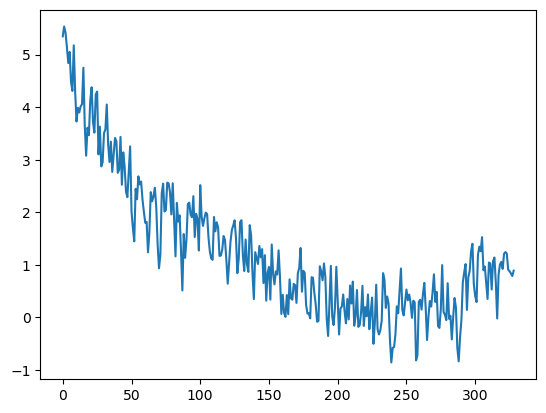

In [32]:
plt.plot(X[:, 297])
mask[297]

ValueError: vmin, vcenter, and vmax must be in ascending order

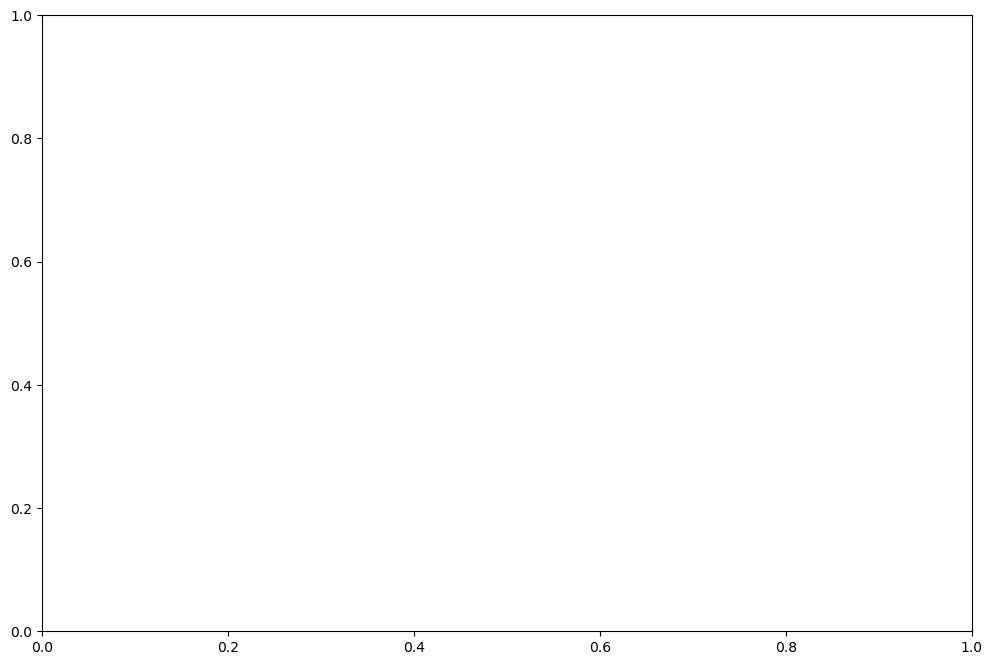

In [17]:
# Set figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Define colormap
cmap = plt.get_cmap("coolwarm")

# Find the maximum and minimum magnitude of neural activity across all neurons for normalization
max_activity = np.max(data)
min_activity = np.min(data)

# Normalize the colors with a center at zero
norm = TwoSlopeNorm(vcenter=0, vmin=min_activity, vmax=max_activity)

# Iterate through each neuron and create colored lines
offset = 1.0
segments = []
colors = []

for i in range(data.shape[1]):
    for j in range(len(time) - 1):
        segment = [
            (time[j], data[j, i] + i * offset),
            (time[j + 1], data[j + 1, i] + i * offset),
        ]
        segments.append(segment)

        color = cmap(norm(data[j, i]))
        colors.append(color)

# Create a LineCollection from segments and set the colors
lc = LineCollection(segments, colors=colors, linewidth=1.2)
ax.add_collection(lc)

# Set the limits of the plot
ax.set_xlim(time[0], time[-1])
ax.set_ylim(-2 * offset, (data.shape[1] + 2) * offset)

# Set yticks and other aesthetics
ytick_positions = [i * offset for i in range(data.shape[1])]
ax.set_yticks(ytick_positions)
ax.set_yticklabels(neurons, fontsize=10)
ax.grid(axis="y", which="both", linestyle="--", linewidth=0.5, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Labeled Neurons")
# ax.set_title(f"{train_or_test.upper()} Dataset: Batch of Neural Activity Sequences")
ax.set_title(f"Combined Dataset: Batch of Neural Activity Sequences")

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Neural Activity")

# Show the plot
plt.tight_layout()
plt.show()